In [ ]:
pip install torchtext==0.5.0

In [ ]:
pip install torchtext

In [ ]:
pip show torchtext

Name: torchtext
Version: 0.5.0
Summary: Text utilities and datasets for PyTorch
Home-page: https://github.com/pytorch/text
Author: PyTorch core devs and James Bradbury
Author-email: jekbradbury@gmail.com
License: BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, torch, tqdm, numpy, sentencepiece, requests
Required-by: 


In [ ]:
pip install ekphrasis

In [ ]:
import pandas as pd
import os
import numpy as np
import torch

from torch import nn, optim
from torchtext.data import Field, Dataset, Example, BucketIterator, Iterator, TabularDataset
from tqdm import tqdm, trange

### The two cells below are for manually importing the helper functions

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil 
import os

from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from tensorflow import keras


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def clean_text(data, normalize_list, annotate_list):
        """
        This function preprocesses the text using the Ekphrasis library
        
        data: Pandas series object containing strings of text

        normalize_list: list of data features to clean

        annotate_list: list of data features to annotate
        """

        text_processor = TextPreProcessor(
            normalize= normalize_list,
            annotate= annotate_list,
            fix_html=True,
            segmenter="twitter", 
            unpack_hashtags=True,  
            unpack_contractions=True,  
            spell_correct_elong=True,  
            tokenizer=SocialTokenizer(lowercase=True).tokenize,
            dicts=[emoticons]
        )

        clean_data = data.map(lambda x: " ".join(text_processor.pre_process_doc(x)))

        return clean_data


def early_stopping(val_loss_values, early_stop_vals):
    """
    Determines whether or not the model will keep running based on the patience and delta given relative to the val loss
    """
    if len(val_loss_values) > early_stop_vals["patience"]:
      if val_loss_values[-1] <= np.mean(np.array(val_loss_values[-1-early_stop_vals["patience"]:-1])) - early_stop_vals["delta"]:
        return False
      else:
        return True
    else:
      return False


def training_plot(train_loss_values, val_loss_values):
    """
    Plots loss after each epoch

    training_loss_values: list of floats; output from fine_tune function

    val_loss_values: list of floats; output from fine_tune function
    """
    sns.set(style='darkgrid')
    plt.rcParams["figure.figsize"] = (12,6)

    plt.plot(train_loss_values, 'b-o', label="train")
    plt.plot(val_loss_values, 'g-o', label="valid")

    #plt.title("Training and Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    #plt.savefig("dogwhistle_train_plot.png",bbox_inches='tight')

    return plt.show()


def metrics(labels, preds, argmax_needed: bool = False):
    """
    Returns the Matthew's correlation coefficient, accuracy rate, true positive rate, true negative rate, false positive rate, false negative rate, precission, recall, and f1 score
    
    labels: list of correct labels

    pred: list of model predictions
    """
    labels = labels
    preds = preds

    if argmax_needed == True:
        preds = np.argmax(preds, axis=1).flatten()

    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    f1 = f1_score(labels, preds, average= "weighted")
    precision = precision_score(labels, preds, average= "weighted")
    recall = recall_score(labels, preds, average= "weighted")

    results = {
        "mcc": mcc,
        "acc": acc,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    
    return results, labels, preds


def model_saver(model, model_type, output_directory, training_dict, labels, preds, ids, results, tokenizer= None):
    """
    Saves PyTorch Model and other outputs

    model: Model to be saved
    
    model_type (string): Name of model
    
    output_directory: Directory to folder to save file in

    training_dict: Dictionary of training and validation values 

    labels: List of labels for test set

    preds: List of model predictions after passed through argmax()

    ids: List of tweet ids

    results: Dictionary of metrics

    tokenizer: Tokenizer to be saved. Defaulted to None.
    """

    output_directory = os.path.join(output_directory, model_type)
    
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    os.chdir(output_directory)

    np.save(model_type+"_dogwhistle_train_results.npy", training_dict) #save training dict
    np.save(model_type+"_dogwhistle_test_results.npy", results) #save test metrics
    
    test_predictions = pd.DataFrame([labels, preds, ids]) #save predictions, labels, and ids
    test_predictions = test_predictions.T
    test_predictions = test_predictions.rename(columns={0: "Labels", 1: 'Predictions', 2: 'image_number'})
    test_predictions.to_csv(model_type+"_dogwhistle_predictions.csv")

    #save models
    torch.save(model.state_dict(), model_type+"_model")

    return print("Saving complete.")



def confusion_matrix_plotter(results, save_name, x_tick_labels, y_tick_labels, color):
    """
    Plots confusion matrix

    results: dictionary item containing key of confusion matrix (output of sklearn confusion_matrix())

    x_tick_labels: list of tick labels on x axis

    y_tick_labels: list of tick labels on y axis

    save_name: name of image to be produced with .png

    color: color selection from matplotlib cmap choices: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    """

    df_cm = pd.DataFrame(results.ravel()[0]["confusion_matrix"])

    fig = plt.figure(figsize=(16, 12))
    
    plt.rc('axes', labelsize=14)  
    plt.rc('xtick', labelsize=12)   
    plt.rc('ytick', labelsize=12)       

    #plt.subplot(2, 2, 1)
    g1 = sns.heatmap(df_cm, annot=True, fmt='g', cmap=color)
    g1.set_xlabel('Predicted Label')
    g1.set_ylabel('True Label', rotation=0) 
    g1.xaxis.set_ticklabels(x_tick_labels, rotation=0) 
    g1.yaxis.set_ticklabels(y_tick_labels, rotation=0) 

    plt.show()

    return fig.savefig(save_name,bbox_inches='tight')


def combine_text(df):
    """
    Combines tweet and image text into one column

    df: Dataframe which holds the data
    """
    combined_text = []

    for row_num in range(len(df)):
        tweet_text = df.loc[row_num, "tweet_text"]
        image_text = df.loc[row_num, "img_text"]
        if type(image_text) == str:
            combined_text.append(tweet_text + image_text)
        else:
            combined_text.append(tweet_text)

    return combined_text


### Prepare Data

In [ ]:
NORMALIZE_LIST = ['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number']
ANNOTATE_LIST = ['hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored']


# Load data
train = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Train/dog_whistle_train.csv", encoding='utf-8')
dev = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Validation/dog_whistle_dev.csv", encoding='utf-8')
test = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Test/dog_whistle_test.csv", encoding='utf-8')

# Combine Image and Tweet Text
train["text"] = combine_text(train)
dev["text"] = combine_text(dev)
test["text"] = combine_text(test)

# Clean data
train["text"] = clean_text(train["text"], NORMALIZE_LIST, ANNOTATE_LIST)
dev["text"] = clean_text(dev["text"], NORMALIZE_LIST, ANNOTATE_LIST)
test["text"] = clean_text(test["text"], NORMALIZE_LIST, ANNOTATE_LIST)

# Rename label column 
train["labels"] = train["Unimodal_text_numeric"]
dev["labels"] = dev["Unimodal_text_numeric"]
test["labels"] = test["Primary_numeric_gt"]

# Subset with necessary data
train_use = train[["text", "labels", "image_number"]]
dev_use = dev[["text", "labels", "image_number"]]
test_use = test[["text", "labels", "image_number"]]

# Define fields
TEXT = Field(sequential=True, tokenize="spacy", include_lengths=True) 
LABEL = Field(sequential=False, use_vocab=False)
IDS = Field(sequential=False, use_vocab=False)
fields = [('text', TEXT), ('labels', LABEL), ('image_number', IDS)] 

# Create datasets
train_set = Dataset([Example.fromlist(i, fields) for i in train_use.values.tolist()], fields=fields)
dev_set = Dataset([Example.fromlist(i, fields) for i in dev_use.values.tolist()], fields=fields)
test_set = Dataset([Example.fromlist(i, fields) for i in test_use.values.tolist()], fields=fields)

# Get training words and pretrained vectors (training words without vectors are initialized randomly)
TEXT.build_vocab(train_set, vectors='fasttext.simple.300d', unk_init=torch.Tensor.normal_)

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...


.vector_cache/wiki.simple.vec: 293MB [00:13, 22.0MB/s]                           
100%|█████████▉| 110782/111051 [00:15<00:00, 7152.91it/s]

In [ ]:
test_use[test_use["image_number"]==1107753891452645377]

,text,labels,image_number
364,easy . breezy . beautiful . north side nigga ✨...,3,1107753891452645377


## Model Setup

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, train, dev, test, pad_id, input_dim: int, embedding_dim: int=300, hidden_dim: int=256, output_dim: int=4, n_layers: int=2, dropout: float=0.2, bidirectional: bool=True, batch_size: int=64):
        """
        train: dataset object of training data

        dev: dataset object of dev data

        test: dataset object of test data
        
        pad_id: pads output with embedding vector
        
        input_dim (int): length of text
        
        embedding_dim (int): number of embedding dimensions defaulted to 300
        
        hidden_dim (int): number of hidden nodes defaulted to 256
        
        output_dim (int): number of labels in classification task defaulted to 2
        
        n_layers (int): number of recurrent layers defaulted to 2
        
        dropout (float): percent on nodes turned off during training defaulted to 0.2

        bidirectional (boolean): whether bidirectional layers will be added, defaulted to True

        batch_size (int): size of mini batches
        """
        
        super(LSTMClassifier, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_iter, self.dev_iter, self.test_iter = BucketIterator.splits((train, dev, test), 
                                                                                batch_size=batch_size, 
                                                                                device=self.device, 
                                                                                sort_key=lambda x: len(x.text), 
                                                                                sort_within_batch=True
                                                                                )

        self.output_dim = output_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_id)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sig = nn.Sigmoid()


    def forward(self, text, lengths):
        """
        This function sets up the model's foward pass

        Initiates forward pass of data
        
        text: vector representation of text string
        
        lengths: second element in bucket iterator
        """

        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths) #,batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        outputs=self.fc(hidden)
        
        return outputs
      
    
    def trainer(self, model, learning_rate: float, early_stop_vals, epochs: int=50):
        """
        This function trains the model

        model: Instantiation of model

        learning_rate (float): determines steps size while minimizing loss function
        
        early_stop_vals: Dictionary containing patience level and minimum improvement delta
        
        epochs (int): Number of training epochs defaulted to 50
        """

        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        model = model.to(self.device)
        
        train_scores, train_losses, val_scores, val_losses, = [], [], [], []
        
        for epoch in trange(epochs, desc= "Epoch"):
            print("Processing epoch {}".format(epoch+1))
            if early_stopping(val_losses, early_stop_vals) == False:

                model.train()

                train_acc = 0
                batch_train_losses = []

                for step, batch in enumerate(self.train_iter): # Loop over mini-batches

                    optimizer.zero_grad()

                    text, lengths = batch.text

                    if self.output_dim ==  1:
                        predictions = model(text, lengths).squeeze()
                        criterion = nn.BCELogits().to(self.device)
                        loss = criterion(predictions, batch.labels.to(self.device, dtype=torch.float)) 
                        loss.backward() # Backpropagate loss
                        optimizer.step() # Update weights
                        train_acc += self.binary_accuracy(predictions, batch.labels).item()
                        batch_train_losses.append(loss.tolist())
                    else:
                        predictions = model(text, lengths)
                        criterion = nn.CrossEntropyLoss().to(self.device)
                        loss = criterion(predictions, batch.labels) 
                        loss.backward() # Backpropagate loss
                        optimizer.step() # Update weights
                        train_acc += self.batch_accuracy(predictions, batch.labels).item() 
                        batch_train_losses.append(loss.tolist())


                batch_loss = sum(batch_train_losses)/len(batch_train_losses)
                train_losses.append(batch_loss)
                train_acc /= len(self.train_iter)
                train_scores.append(train_acc)
                print('Accuracy on train data:\t{:.4f}'.format(train_acc))
                model.eval() # Compute accuracy on validation data

                val_acc = 0
                batch_val_losses = []

                with torch.no_grad():

                    for batch in self.dev_iter:

                        text, lengths = batch.text

                        if self.output_dim ==  1:
                            preds = model(text, lengths).squeeze()
                            criterion = nn.BCELogits().to(self.device)
                            loss = criterion(preds, batch.labels.to(self.device, dtype=torch.float)) 
                            batch_val_losses.append(loss.tolist())
                            val_acc += self.binary_accuracy(preds, batch.label).item()
                        else:
                            preds = model(text, lengths)
                            criterion = nn.CrossEntropyLoss().to(self.device)
                            loss = criterion(preds, batch.labels) 
                            batch_val_losses.append(loss.tolist())
                            val_acc += self.batch_accuracy(preds, batch.labels).item()
                        

                batch_loss = sum(batch_val_losses)/len(batch_val_losses)
                print("Batch dev loss: {}".format(batch_loss))
                val_losses.append(batch_loss)
                val_acc /= len(self.dev_iter)
                val_scores.append(val_acc)

                print('Accuracy on dev data:\t{:.4f}'.format(val_acc))
                
                if epoch == (epochs-1):
                    training_plot(train_losses, val_losses)
                    training_dict = {"Train Accuracy": train_scores, "Train Loss": train_losses, "Val Accuracy": val_scores, "Val Loss": val_losses}
                    print("Training complete!")
                    return training_dict
                else:
                    continue
                
            else:
                print("Stopping early...")
                print("Training complete!")
                training_plot(train_losses, val_losses)
                training_dict = {"Train Accuracy": train_scores, "Train Loss": train_losses, "Val Accuracy": val_scores, "Val Loss": val_losses}
                print("Training complete!")
                return training_dict


    def test(self, model):
        """
        This function performs a forward pass on the test data and computes the performance metrics

        model: instantiation of model
        """
        
        model = model.to(self.device)
        model.eval()

        labels = list()
        preds = list()
        ids = list()

        with torch.no_grad():

            for batch in self.test_iter:

                text, lengths = batch.text
                output = model(text, lengths)

                preds.extend([p.item() for p in output.argmax(dim=1, keepdim=True)])
                labels.extend([l.item() for l in batch.labels])
                ids.extend([i.item() for i in batch.image_number])
        
        return metrics(labels, preds), ids


    def batch_accuracy(self, predictions, labels):
        """
        Calculates mean batch accuracy for multiclass data
        
        predictions: model output after forward pass
        
        labels: list of one-hot encoded labels
        """
        
        max_predictions = predictions.argmax(dim=1, keepdim=True)
        correct = max_predictions.squeeze(1).eq(labels)
        
        return correct.sum() / torch.FloatTensor([labels.shape[0]])


    def binary_accuracy(self, predictions, labels):
        """
        Calculates mean batch accuracy for binary data

        predictions: model output after forward pass
          
        labels: list of one-hot encoded labels
        """
        rounded_preds = torch.round(self.sig(predictions))
        
        correct = (rounded_preds == labels).float() 
        acc = correct.sum() / len(correct)
        
        return acc
      

### Run Model

In [ ]:
#define hyperparameters
INPUT_DIM = len(TEXT.vocab)
PAD_ID = TEXT.vocab.stoi[TEXT.pad_token]
UNK_ID = TEXT.vocab.stoi[TEXT.unk_token]
N_EPOCHS = 50
EARLY_STOPPING = {"patience": 10, "delta": 0.01}
LEARNING_RATES = [0.0001, 0.001, 0.01, 0.1, 1]
OUTPUT_DIR = "/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text"










Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Processing epoch 1











Epoch:   2%|▏         | 1/50 [00:04<03:16,  4.01s/it]

Accuracy on train data:	0.5217
Batch dev loss: 0.9548793658614159
Accuracy on dev data:	0.5717


Processing epoch 2











Epoch:   4%|▍         | 2/50 [00:07<03:09,  3.95s/it]

Accuracy on train data:	0.5816
Batch dev loss: 0.8914645463228226
Accuracy on dev data:	0.6118
Processing epoch 3











Epoch:   6%|▌         | 3/50 [00:11<03:04,  3.92s/it]

Accuracy on train data:	0.6353
Batch dev loss: 0.8282544314861298
Accuracy on dev data:	0.6881
Processing epoch 4











Epoch:   8%|▊         | 4/50 [00:15<02:59,  3.90s/it]

Accuracy on train data:	0.6956
Batch dev loss: 0.7546292915940285
Accuracy on dev data:	0.7163
Processing epoch 5











Epoch:  10%|█         | 5/50 [00:19<02:54,  3.88s/it]

Accuracy on train data:	0.7157
Batch dev loss: 0.734233058989048
Accuracy on dev data:	0.7270


Processing epoch 6











Epoch:  12%|█▏        | 6/50 [00:23<02:50,  3.87s/it]

Accuracy on train data:	0.7429
Batch dev loss: 0.7189418897032738
Accuracy on dev data:	0.7222


Processing epoch 7











Epoch:  14%|█▍        | 7/50 [00:27<02:46,  3.86s/it]

Accuracy on train data:	0.7547
Batch dev loss: 0.8316294699907303
Accuracy on dev data:	0.6828
Processing epoch 8











Epoch:  16%|█▌        | 8/50 [00:30<02:41,  3.86s/it]

Accuracy on train data:	0.7697
Batch dev loss: 0.6966468468308449
Accuracy on dev data:	0.7505
Processing epoch 9











Epoch:  18%|█▊        | 9/50 [00:34<02:37,  3.85s/it]

Accuracy on train data:	0.7674
Batch dev loss: 0.7173378244042397
Accuracy on dev data:	0.7159
Processing epoch 10











Epoch:  20%|██        | 10/50 [00:38<02:33,  3.84s/it]

Accuracy on train data:	0.7853
Batch dev loss: 0.6888263374567032
Accuracy on dev data:	0.7515
Processing epoch 11











Epoch:  22%|██▏       | 11/50 [00:42<02:29,  3.84s/it]

Accuracy on train data:	0.8141
Batch dev loss: 0.6936726123094559
Accuracy on dev data:	0.7520


Processing epoch 12











Epoch:  24%|██▍       | 12/50 [00:46<02:25,  3.83s/it]

Accuracy on train data:	0.8178
Batch dev loss: 0.7216378152370453
Accuracy on dev data:	0.7426
Processing epoch 13











Epoch:  26%|██▌       | 13/50 [00:50<02:21,  3.83s/it]

Accuracy on train data:	0.8390
Batch dev loss: 0.710201621055603
Accuracy on dev data:	0.7480


Processing epoch 14











Epoch:  28%|██▊       | 14/50 [00:53<02:17,  3.83s/it]

Accuracy on train data:	0.8566
Batch dev loss: 0.7350601926445961
Accuracy on dev data:	0.7422
Processing epoch 15
Stopping early...
Training complete!


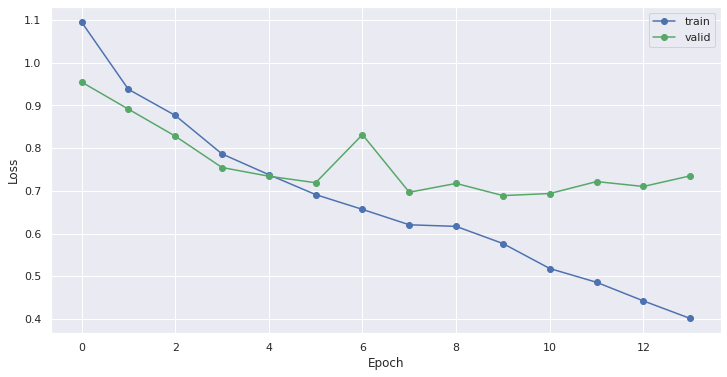

Training complete!


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))










Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Saving complete.
The new best learning rate is  0.0001
Processing epoch 1












Epoch:   2%|▏         | 1/50 [00:03<03:07,  3.83s/it]

Accuracy on train data:	0.5706
Batch dev loss: 0.7999562993645668
Accuracy on dev data:	0.6974
Processing epoch 2












Epoch:   4%|▍         | 2/50 [00:07<03:04,  3.84s/it]

Accuracy on train data:	0.7069
Batch dev loss: 0.7561765983700752
Accuracy on dev data:	0.7281
Processing epoch 3












Epoch:   6%|▌         | 3/50 [00:11<03:00,  3.84s/it]

Accuracy on train data:	0.7899
Batch dev loss: 0.7020666152238846
Accuracy on dev data:	0.7479


Processing epoch 4












Epoch:   8%|▊         | 4/50 [00:15<02:56,  3.84s/it]

Accuracy on train data:	0.8415
Batch dev loss: 0.7612165212631226
Accuracy on dev data:	0.7456












Epoch:  10%|█         | 5/50 [00:19<02:52,  3.84s/it]

Processing epoch 5
Accuracy on train data:	0.8916
Batch dev loss: 0.9388282373547554
Accuracy on dev data:	0.7300
Processing epoch 6












Epoch:  12%|█▏        | 6/50 [00:23<02:48,  3.84s/it]

Accuracy on train data:	0.9218
Batch dev loss: 0.8835848197340965
Accuracy on dev data:	0.7417
Processing epoch 7












Epoch:  14%|█▍        | 7/50 [00:26<02:44,  3.83s/it]

Accuracy on train data:	0.9449
Batch dev loss: 1.0154915824532509
Accuracy on dev data:	0.7242
Processing epoch 8












Epoch:  16%|█▌        | 8/50 [00:30<02:40,  3.82s/it]

Accuracy on train data:	0.9655
Batch dev loss: 1.1819842457771301
Accuracy on dev data:	0.6998


Processing epoch 9












Epoch:  18%|█▊        | 9/50 [00:34<02:36,  3.82s/it]

Accuracy on train data:	0.9792
Batch dev loss: 1.3653292804956436
Accuracy on dev data:	0.7300
Processing epoch 10












Epoch:  20%|██        | 10/50 [00:38<02:32,  3.82s/it]

Accuracy on train data:	0.9831
Batch dev loss: 1.4718933552503586
Accuracy on dev data:	0.7290
Processing epoch 11












Epoch:  22%|██▏       | 11/50 [00:42<02:28,  3.82s/it]

Accuracy on train data:	0.9774
Batch dev loss: 1.3380195498466492
Accuracy on dev data:	0.7105


Processing epoch 12
Stopping early...
Training complete!


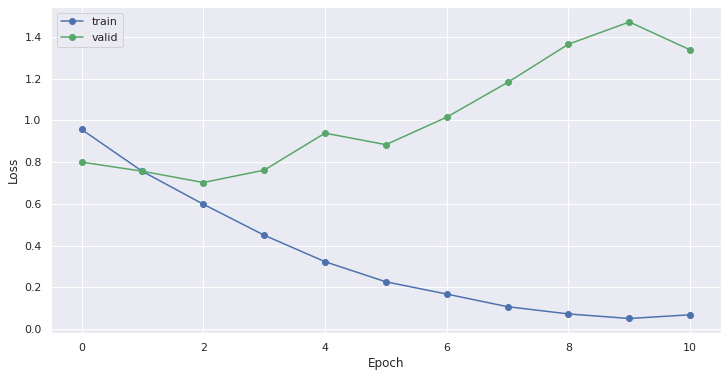

Training complete!













Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Processing epoch 1


Accuracy on train data:	0.5118
Batch dev loss: 0.9455111548304558
Accuracy on dev data:	0.5679


Epoch:   2%|▏         | 1/50 [00:03<03:06,  3.81s/it]

Processing epoch 2













Epoch:   4%|▍         | 2/50 [00:07<03:02,  3.81s/it]

Accuracy on train data:	0.5718
Batch dev loss: 0.9381448552012444
Accuracy on dev data:	0.5660


Processing epoch 3













Epoch:   6%|▌         | 3/50 [00:11<02:59,  3.81s/it]

Accuracy on train data:	0.6257
Batch dev loss: 0.9359739497303963
Accuracy on dev data:	0.6202
Processing epoch 4













Epoch:   8%|▊         | 4/50 [00:15<02:55,  3.81s/it]

Accuracy on train data:	0.7227
Batch dev loss: 0.8113228529691696
Accuracy on dev data:	0.7100


Processing epoch 5













Epoch:  10%|█         | 5/50 [00:19<02:51,  3.81s/it]

Accuracy on train data:	0.7921
Batch dev loss: 0.8578011095523834
Accuracy on dev data:	0.7022


Processing epoch 6













Epoch:  12%|█▏        | 6/50 [00:22<02:47,  3.81s/it]

Accuracy on train data:	0.8429
Batch dev loss: 0.9224472194910049
Accuracy on dev data:	0.6657


Processing epoch 7













Epoch:  14%|█▍        | 7/50 [00:26<02:43,  3.81s/it]

Accuracy on train data:	0.8635
Batch dev loss: 0.9726739674806595
Accuracy on dev data:	0.7003


Processing epoch 8













Epoch:  16%|█▌        | 8/50 [00:30<02:40,  3.82s/it]

Accuracy on train data:	0.8835
Batch dev loss: 1.0351909175515175
Accuracy on dev data:	0.6877
Processing epoch 9
Accuracy on train data:	0.9092













Epoch:  18%|█▊        | 9/50 [00:34<02:36,  3.82s/it]

Batch dev loss: 1.1647212356328964
Accuracy on dev data:	0.6818
Processing epoch 10













Epoch:  20%|██        | 10/50 [00:38<02:32,  3.81s/it]

Accuracy on train data:	0.9208
Batch dev loss: 1.0976117998361588
Accuracy on dev data:	0.6855
Processing epoch 11


Accuracy on train data:	0.9288
Batch dev loss: 1.2302363067865372
Accuracy on dev data:	0.6964


Epoch:  22%|██▏       | 11/50 [00:41<02:28,  3.82s/it]

Processing epoch 12
Stopping early...
Training complete!


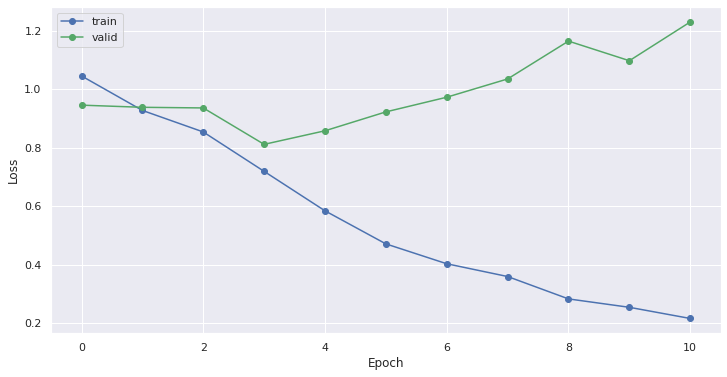

Training complete!














Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Processing epoch 1














Epoch:   2%|▏         | 1/50 [00:03<03:06,  3.81s/it]

Accuracy on train data:	0.4293
Batch dev loss: 2.2478518933057785
Accuracy on dev data:	0.5309


Processing epoch 2














Epoch:   4%|▍         | 2/50 [00:07<03:02,  3.81s/it]

Accuracy on train data:	0.4607
Batch dev loss: 1.6687604486942291
Accuracy on dev data:	0.5309
Processing epoch 3














Epoch:   6%|▌         | 3/50 [00:11<02:58,  3.80s/it]

Accuracy on train data:	0.4550
Batch dev loss: 1.551565408706665
Accuracy on dev data:	0.3744
Processing epoch 4














Epoch:   8%|▊         | 4/50 [00:15<02:54,  3.80s/it]

Accuracy on train data:	0.4587
Batch dev loss: 1.7858467772603035
Accuracy on dev data:	0.4715
Processing epoch 5














Epoch:  10%|█         | 5/50 [00:18<02:50,  3.80s/it]

Accuracy on train data:	0.4859
Batch dev loss: 1.264754205942154
Accuracy on dev data:	0.5918
Processing epoch 6














Epoch:  12%|█▏        | 6/50 [00:22<02:47,  3.80s/it]

Accuracy on train data:	0.4941
Batch dev loss: 1.9381206631660461
Accuracy on dev data:	0.4040
Processing epoch 7














Epoch:  14%|█▍        | 7/50 [00:26<02:43,  3.80s/it]

Accuracy on train data:	0.4840
Batch dev loss: 1.0816597044467926
Accuracy on dev data:	0.5739
Processing epoch 8














Epoch:  16%|█▌        | 8/50 [00:30<02:39,  3.80s/it]

Accuracy on train data:	0.5121
Batch dev loss: 1.615753412246704
Accuracy on dev data:	0.4223
Processing epoch 9














Epoch:  18%|█▊        | 9/50 [00:34<02:36,  3.81s/it]

Accuracy on train data:	0.4827
Batch dev loss: 2.8956023305654526
Accuracy on dev data:	0.5104


Processing epoch 10














Epoch:  20%|██        | 10/50 [00:38<02:32,  3.80s/it]

Accuracy on train data:	0.5306
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 11














Epoch:  22%|██▏       | 11/50 [00:41<02:28,  3.80s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 12
Stopping early...
Training complete!


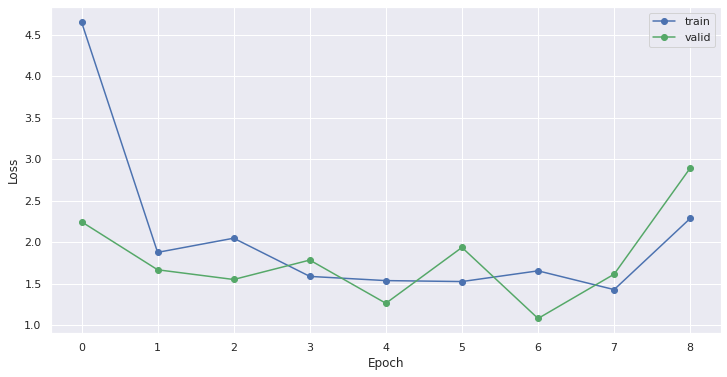

Training complete!


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)













Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Processing epoch 1















Epoch:   2%|▏         | 1/50 [00:03<03:05,  3.79s/it]

Accuracy on train data:	0.4350
Batch dev loss: 18.9593425989151
Accuracy on dev data:	0.4543
Processing epoch 2















Epoch:   4%|▍         | 2/50 [00:07<03:01,  3.79s/it]

Accuracy on train data:	0.4940
Batch dev loss: nan
Accuracy on dev data:	0.5309


Processing epoch 3















Epoch:   6%|▌         | 3/50 [00:11<02:58,  3.79s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309


Processing epoch 4















Epoch:   8%|▊         | 4/50 [00:15<02:54,  3.80s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 5















Epoch:  10%|█         | 5/50 [00:18<02:50,  3.80s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309


Processing epoch 6















Epoch:  12%|█▏        | 6/50 [00:22<02:47,  3.80s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 7















Epoch:  14%|█▍        | 7/50 [00:26<02:43,  3.79s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 8















Epoch:  16%|█▌        | 8/50 [00:30<02:39,  3.80s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309















Epoch:  18%|█▊        | 9/50 [00:34<02:35,  3.80s/it]

Processing epoch 9
Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 10















Epoch:  20%|██        | 10/50 [00:37<02:31,  3.80s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309


Processing epoch 11















Epoch:  22%|██▏       | 11/50 [00:41<02:27,  3.79s/it]

Accuracy on train data:	0.5334
Batch dev loss: nan
Accuracy on dev data:	0.5309
Processing epoch 12
Stopping early...
Training complete!


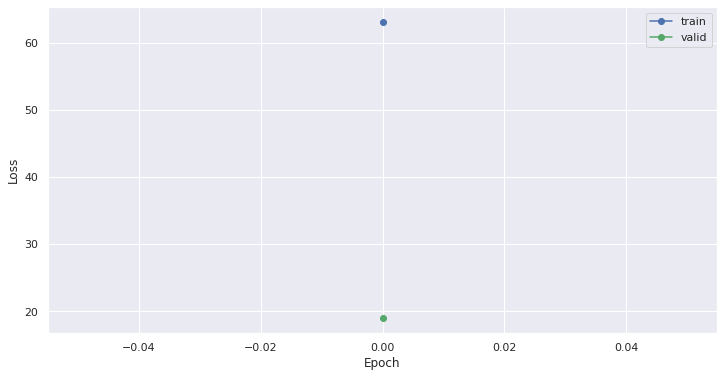

Training complete!


In [ ]:
results_dict = {}
max_f1_value = 0

for i in LEARNING_RATES:
    # Initialize LSTM model
    model = LSTMClassifier(train_set, dev_set, test_set, PAD_ID, INPUT_DIM)  

    # Load pretrained vector
    model.embedding.weight.data.copy_(TEXT.vocab.vectors) 

    # Manually initialize UNK and PAD tokens as zero vectors (and NOT randomly as would be done otherwise)
    model.embedding.weight.data[UNK_ID] = torch.zeros(300)
    model.embedding.weight.data[PAD_ID] = torch.zeros(300)

    #model test
    train_dict = model.trainer(model, i, EARLY_STOPPING, N_EPOCHS) 
    (results_dict[i], labels, preds), ids = model.test(model)

    if results_dict[i]["f1"] >= max_f1_value: #only save best model
        max_f1_value = results_dict[i]["f1"]
        model_saver(model, "LSTM", OUTPUT_DIR, train_dict, labels, preds, ids, results_dict[i])
        print("The new best learning rate is ", i)

# save complete training results
np.save(os.path.join(OUTPUT_DIR, "LSTM/LSTM_dogwhistle_total_training_results.npy"), results_dict)
df = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_dogwhistle_predictions.csv")
# df["image_number"] = ids
# df.to_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_dogwhistle_predictions.csv")

In [ ]:
print(labels[:10])
print(ids[:10])

[0, 1, 0, 3, 0, 0, 3, 0, 3, 0]
[1059508332560613378, 1108701637957300224, 1107677359652642816, 1107753891452645377, 1058592078425276416, 1106580970629681152, 1115769250197565440, 1116042450991075328, 1063901397085839360, 1116865207761022977]


In [ ]:
max_f1_value

0.7190877940746235

In [ ]:
results_dict

{0.0001: {'acc': 0.7370517928286853,
  'confusion_matrix': array([[218,  40,   0,  10],
         [ 40, 144,   0,   1],
         [  5,   7,   0,   0],
         [ 22,   7,   0,   8]]),
  'f1': 0.7190877940746235,
  'mcc': 0.5231888648772295,
  'precision': 0.7074121377329597,
  'recall': 0.7190877940746235},
 0.001: {'acc': 0.7071713147410359,
  'confusion_matrix': array([[205,  42,   2,  19],
         [ 40, 135,   6,   4],
         [  4,   6,   2,   0],
         [ 19,   4,   1,  13]]),
  'f1': 0.7062534507209304,
  'mcc': 0.48798330343540364,
  'precision': 0.7053766514453179,
  'recall': 0.7062534507209304},
 0.01: {'acc': 0.6912350597609562,
  'confusion_matrix': array([[216,  44,   1,   7],
         [ 52, 127,   6,   0],
         [  5,   6,   1,   0],
         [ 27,   7,   0,   3]]),
  'f1': 0.6715110828935189,
  'mcc': 0.4360559470903061,
  'precision': 0.6638450545643513,
  'recall': 0.6715110828935189},
 0.1: {'acc': 0.5338645418326693,
  'confusion_matrix': array([[268,   0,   0,

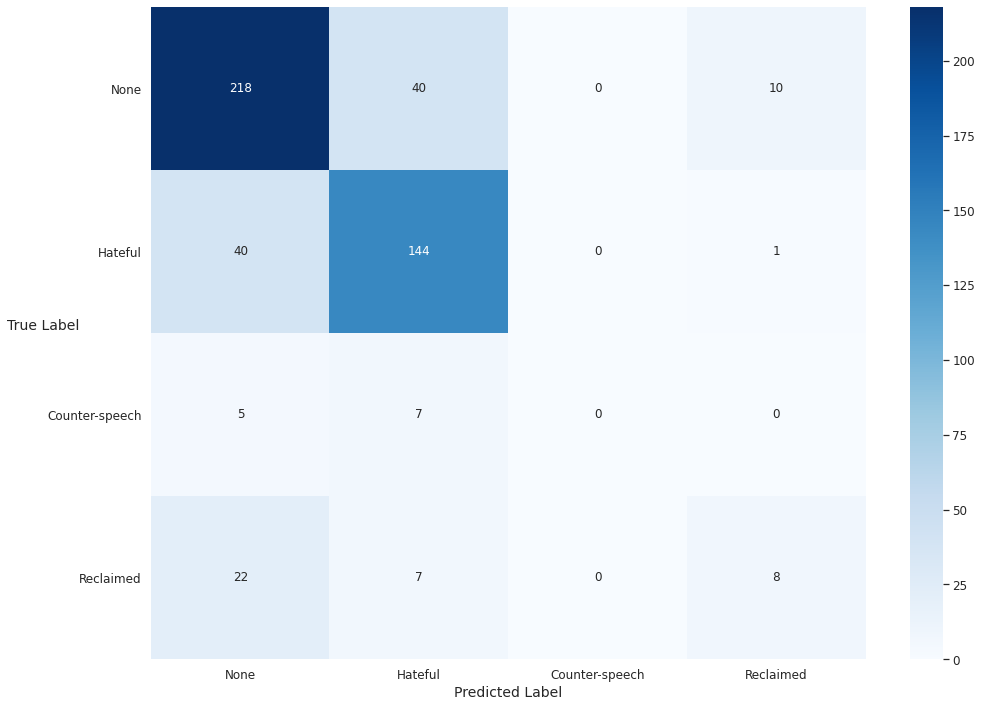

In [ ]:
X_TICK_LABELS = ["None", "Hateful", "Counter-speech", "Reclaimed"]
Y_TICK_LABELS = ["None", "Hateful", "Counter-speech", "Reclaimed"]
COLOR = "Blues"
SAVE_NAME = "/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_cm_dogwhistle.png"
CM = np.load("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_dogwhistle_test_results.npy", allow_pickle=True)

confusion_matrix_plotter(CM, SAVE_NAME, X_TICK_LABELS, Y_TICK_LABELS, COLOR)

### Investigating how datasize effects performance

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...
Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading english - 1grams ...


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Processing epoch 1


Epoch:   2%|▏         | 1/50 [00:01<01:14,  1.52s/it]

Accuracy on train data:	0.5312
Batch dev loss: 0.9419197589159012
Accuracy on dev data:	0.6044
Processing epoch 2


Epoch:   4%|▍         | 2/50 [00:02<01:11,  1.50s/it]

Accuracy on train data:	0.5951
Batch dev loss: 0.8883729353547096
Accuracy on dev data:	0.6239
Processing epoch 3


Epoch:   6%|▌         | 3/50 [00:04<01:10,  1.49s/it]

Accuracy on train data:	0.6523
Batch dev loss: 0.7834524065256119
Accuracy on dev data:	0.7163
Processing epoch 4


Epoch:   8%|▊         | 4/50 [00:05<01:08,  1.48s/it]

Accuracy on train data:	0.6836
Batch dev loss: 0.7567043676972389
Accuracy on dev data:	0.7037
Processing epoch 5


Epoch:  10%|█         | 5/50 [00:07<01:06,  1.48s/it]

Accuracy on train data:	0.7151
Batch dev loss: 0.7270165234804153
Accuracy on dev data:	0.7305
Processing epoch 6


Epoch:  12%|█▏        | 6/50 [00:08<01:04,  1.47s/it]

Accuracy on train data:	0.7372
Batch dev loss: 0.7298048585653305
Accuracy on dev data:	0.7154
Processing epoch 7


Epoch:  14%|█▍        | 7/50 [00:10<01:03,  1.47s/it]

Accuracy on train data:	0.7369
Batch dev loss: 0.7061617821455002
Accuracy on dev data:	0.7305
Processing epoch 8


Epoch:  16%|█▌        | 8/50 [00:11<01:01,  1.47s/it]

Accuracy on train data:	0.7599
Batch dev loss: 0.7209761887788773
Accuracy on dev data:	0.7387
Processing epoch 9


Epoch:  18%|█▊        | 9/50 [00:13<00:59,  1.46s/it]

Accuracy on train data:	0.7722
Batch dev loss: 0.739792212843895
Accuracy on dev data:	0.7257
Processing epoch 10


Epoch:  20%|██        | 10/50 [00:14<00:58,  1.46s/it]

Accuracy on train data:	0.7845
Batch dev loss: 0.7229087874293327
Accuracy on dev data:	0.7368
Processing epoch 11


Epoch:  22%|██▏       | 11/50 [00:16<00:56,  1.46s/it]

Accuracy on train data:	0.7948
Batch dev loss: 0.6934195980429649
Accuracy on dev data:	0.7568
Processing epoch 12


Epoch:  24%|██▍       | 12/50 [00:17<00:55,  1.46s/it]

Accuracy on train data:	0.8136
Batch dev loss: 0.6803746521472931
Accuracy on dev data:	0.7524
Processing epoch 13


Epoch:  26%|██▌       | 13/50 [00:19<00:54,  1.46s/it]

Accuracy on train data:	0.8251
Batch dev loss: 0.7208217680454254
Accuracy on dev data:	0.7398
Processing epoch 14
Stopping early...
Training complete!


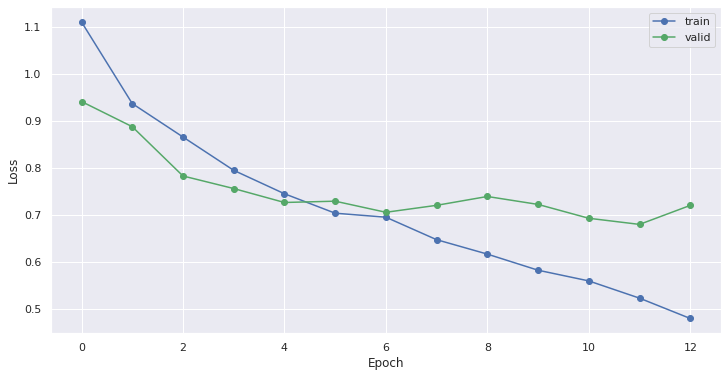

Training complete!
{'mcc': 0.0, 'acc': 0.8571428571428571, 'confusion_matrix': array([[  0,   0],
       [ 17, 102]]), 'precision': 1.0, 'recall': 0.923076923076923, 'f1': 0.923076923076923}
{'mcc': 0.0, 'acc': 0.7878787878787878, 'confusion_matrix': array([[ 0,  0],
       [14, 52]]), 'precision': 1.0, 'recall': 0.8813559322033898, 'f1': 0.8813559322033898}
{'mcc': 0.06830955848266018, 'acc': 0.6782334384858044, 'confusion_matrix': array([[214,  52,   0,   2],
       [  0,   0,   0,   0],
       [  4,   8,   0,   0],
       [ 28,   8,   0,   1]]), 'precision': 0.7743581852222308, 'recall': 0.7098092525991482, 'f1': 0.7098092525991482}
{3500: 0.7018248108483498}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
NOMARLIZE_LIST = ['url', 'email', 'percent', 'money', 'phone', 'user', 'time', 'date', 'number']
ANNOTATE_LIST = ['hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored']


f1_scores = {}

for i in [3500]: #[2000, 2500, 3000]:

    # Load data
    train = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Train/dog_whistle_train.csv", encoding='utf-8')
    train = train[:i]
    dev = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Validation/dog_whistle_dev.csv", encoding='utf-8')
    test = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Test/dog_whistle_test.csv", encoding='utf-8')

    # Combine Image and Tweet Text
    train["text"] = combine_text(train)
    dev["text"] = combine_text(dev)
    test["text"] = combine_text(test)

    # Clean data
    train["text"] = clean_text(train["text"], NOMARLIZE_LIST, ANNOTATE_LIST)
    dev["text"] = clean_text(dev["text"], NOMARLIZE_LIST, ANNOTATE_LIST)
    test["text"] = clean_text(test["text"], NOMARLIZE_LIST, ANNOTATE_LIST)

    # Rename label column 
    train["labels"] = train["Unimodal_text_numeric"]
    dev["labels"] = dev["Unimodal_text_numeric"]
    test["labels"] = test["Primary_numeric_gt"]

    # Subset with necessary data
    train_use = train[["text", "labels", "image_number"]]
    dev_use = dev[["text", "labels", "image_number"]]
    test_use = test[["text", "labels", "image_number"]]

    # Define fields
    TEXT = Field(sequential=True, tokenize="spacy", include_lengths=True) 
    LABEL = Field(sequential=False, use_vocab=False)
    IDS = Field(sequential=False, use_vocab=False)
    fields = [('text', TEXT), ('labels', LABEL), ('image_number', IDS)] 

    # Create datasets
    train_set = Dataset([Example.fromlist(i, fields) for i in train_use.values.tolist()], fields=fields)
    dev_set = Dataset([Example.fromlist(i, fields) for i in dev_use.values.tolist()], fields=fields)
    test_set = Dataset([Example.fromlist(i, fields) for i in test_use.values.tolist()], fields=fields)

    # Get training words and pretrained vectors (training words without vectors are initialized randomly)
    TEXT.build_vocab(train_set, vectors='fasttext.simple.300d', unk_init=torch.Tensor.normal_)

    INPUT_DIM = len(TEXT.vocab)
    PAD_ID = TEXT.vocab.stoi[TEXT.pad_token]
    UNK_ID = TEXT.vocab.stoi[TEXT.unk_token]

    # Initialize LSTM model
    model = LSTMClassifier(train_set, dev_set, test_set, PAD_ID, INPUT_DIM)  

    # Load pretrained vector
    model.embedding.weight.data.copy_(TEXT.vocab.vectors) 

    # Manually initialize UNK and PAD tokens as zero vectors (and NOT randomly as would be done otherwise)
    model.embedding.weight.data[UNK_ID] = torch.zeros(300)
    model.embedding.weight.data[PAD_ID] = torch.zeros(300)

    #model test
    train_dict = model.trainer(model, 0.0001, {"patience": 10, "delta": 0.01}, 50) 
    (results_dict, _, preds), ids = model.test(model)

    df = pd.DataFrame([preds, ids]).T
    df = df.rename(columns= {0: "Predictions", 1: "image_number"})

    f1_scores[i] = results_dict["f1"]


    test = pd.read_csv("/content/drive/My Drive/Dog_Whistle_Code/Data/Test/dog_whistle_test.csv", encoding='utf-8')
    test = pd.merge(test, df, on="image_number")


    dw_df = test[test["Strategies_numeric_gt"] == 2]
    dw_results, _, _ = metrics(dw_df["Primary_numeric_gt"], dw_df["Predictions"])
    print(dw_results)

    explicit_df = test[test["Strategies_numeric_gt"] == 1]
    explicit_results, _, _ = metrics(explicit_df["Primary_numeric_gt"], explicit_df["Predictions"])
    print(explicit_results)

    none_df = test[test["Strategies_numeric_gt"] == 0]
    none_results, _, _ = metrics(none_df["Primary_numeric_gt"], none_df["Predictions"])
    print(none_results)


print(f1_scores)
#np.save(os.path.join("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Text/LSTM/LSTM_datasize_results.npy"), f1_scores)